# Hate Model

In [1]:
!pip install keras
!pip install sklearn
!pip install nltk
!pip install transformers
!pip install ktrain

import matplotlib.pyplot as mpl
import pandas as pd
import numpy as np
import seaborn
from pathlib import Path
from urllib.request import urlopen
import numpy as np
import tensorflow as tf
from urllib.request import urlopen
import nltk
import ktrain
from ktrain import text
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn import metrics
from sklearn.pipeline import FeatureUnion, Pipeline 
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from nltk.stem.snowball import SnowballStemmer
from nltk import word_tokenize, pos_tag_sents
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer, word_tokenize
from keras.preprocessing.sequence import pad_sequences
from nltk.util import pad_sequence
from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.pipeline import Pipeline
from keras.preprocessing.text import Tokenizer

In [2]:
def importHateDatasets(dataset_name):
    # Download a given dataset from GitHub CDN
    # Data cast to global values

    baseUrl = "https://raw.githubusercontent.com/GDarkens/CE888/main/Assignments/Assignment1/tweeteval/datasets/"

    MAPPING_URL = baseUrl + dataset_name + "/" + "mapping.txt"
    global mapping
    mapping = urlopen(MAPPING_URL).read().decode('utf-8').split("\n")

    TEST_LABELS_URL = baseUrl + dataset_name + "/" + "test_labels.txt"
    global test_labels
    test_labels = urlopen(
        TEST_LABELS_URL).read().decode('utf-8').split("\n")

    TEST_TEXT_URL = baseUrl + dataset_name + "/" + "test_text.txt"
    global test_text
    test_text = urlopen(
        TEST_TEXT_URL).read().decode('utf-8').split("\n")

    TRAIN_LABELS_URL = baseUrl + dataset_name + "/" + "train_labels.txt"
    global train_labels
    train_labels = urlopen(
        TRAIN_LABELS_URL).read().decode('utf-8').split("\n")

    TRAIN_TEXT_URL = baseUrl + dataset_name + "/" + "train_text.txt"
    global train_text
    train_text = urlopen(
        TRAIN_TEXT_URL).read().decode('utf-8').split("\n")

    VAL_LABELS_URL = baseUrl + dataset_name + "/" + "val_labels.txt"
    global val_labels
    val_labels = urlopen(
        VAL_LABELS_URL).read().decode('utf-8').split("\n")

    VAL_TEXT_URL = baseUrl + dataset_name + "/" + "val_text.txt"
    global val_text
    val_text = urlopen(
        VAL_TEXT_URL).read().decode('utf-8').split("\n")

In [3]:
def dataFramer(tweetVar, labelVar):
    #Suitably frames tweets, pairing them with their given label
    tweet_array = []
    label_array = []
    for i in range(len(tweetVar)):
        tweet_array.append({"tweet": tweetVar[i], "label": labelVar[i]})
        label_array.append(i)
    dataframe = pd.DataFrame(tweet_array, index=label_array)
    dataframe = dataframe[:-1]  # Drop last row, as is a blank
    return dataframe

In [4]:
importHateDatasets("hate")  # emoji  / hate /  sentiment

trainingTweets = dataFramer(train_text, train_labels)
testingTweets = dataFramer(test_text, test_labels)
valTweets = dataFramer(val_text, val_labels)

## Text Pre-processing

In [5]:
def fullyProcess(tweetFrame):
    # conda activate myenv
    tweetFrame['processed_tweet'] = tweetFrame['tweet'].str.lower()
    tweetFrame['processed_tweet'] = handleRemover(tweetFrame)
    tweetFrame['processed_tweet'] = punctuationRemover(tweetFrame)
    tweetFrame['processed_tweet'] = stopwordRemoval(tweetFrame)
    tweetFrame['processed_tweet'] = stemmer(tweetFrame)
    tweetFrame['processed_tweet'] = tweetFrame['processed_tweet'].str.strip()
    #tweetFrame['processed_tweet'] = tokenizeSequencePadder((tweetFrame))
    
    #tweetFrame['length'] = tweetFrame['processed_tweet'].apply(lambda x: len(x))
    #tweetFrame['words'] = tweetFrame['processed_tweet'].apply(lambda x: len(x.split()))
    return tweetFrame


def stopwordRemoval(tweetFrame):
    en_Stopwords = stopwords.words("english")
    result = tweetFrame['processed_tweet'].apply(lambda x: ' '.join(
        [item for item in x.split() if item not in en_Stopwords]))
    return result


puncTokenizer = RegexpTokenizer(r'\w+')
def punctuationRemover(tweetFrame):
    result = tweetFrame['processed_tweet'].str.replace(r'[^\w\s]+', '')
    return result


def tokenizeSequencePadder(tweetFrame):
    nltkTokenizer = Tokenizer(num_words = 15000)
    nltkTokenizer.fit_on_texts(tweetFrame['processed_tweet'])
    
    tokenizedFrame = nltkTokenizer.texts_to_sequences(tweetFrame['processed_tweet'])
    paddedFrame = pad_sequences(tokenizedFrame, padding = 'post', maxlen = 40)
    return paddedFrame


def tokenizer(tweetFrame):
    result = tweetFrame['tweet'].apply(nltk.word_tokenize)
    return result


def stemmer(tweetFrame):
    result = tweetFrame['processed_tweet'].apply(stem_sentences)
    return result


def stem_sentences(tweet):
    stemmer = SnowballStemmer('english')
    tokenized = tweet.split()
    stemmed = [stemmer.stem(token) for token in tokenized]
    return ' '.join(stemmed)


def handleRemover(tweetFrame):
    result = tweetFrame['processed_tweet'].str.replace('@user', '')
    return result

In [6]:
%%time

train_processedTweets = fullyProcess(trainingTweets)
test_processedTweets = fullyProcess(testingTweets)
val_processedTweets = fullyProcess(valTweets)

Wall time: 2.22 s


In [7]:
# Vectorization of sets
vectorizer = CountVectorizer(input = 'content', analyzer = 'word', max_features = 5000)

train_x = train_processedTweets['processed_tweet']
test_x = test_processedTweets['processed_tweet']
val_x = val_processedTweets['processed_tweet']

train_y = train_processedTweets['label']
test_y = test_processedTweets['label']
val_y = val_processedTweets['label']


# ! N.B. Only training set fitted to model !
vectorTrainProc = vectorizer.fit_transform(train_x)

vectorTestProc = vectorizer.transform(test_x)
vectorTalProc = vectorizer.transform(val_x)



## Dummy Classification

#### 'stratified' Dummy Classification

In [8]:
train_y = trainingTweets['label']

dummyClassifier = DummyClassifier(strategy = 'stratified')
dummyClassifier = dummyClassifier.fit(vectorTrainProc, train_y)

In [9]:
dummyPredictions = dummyClassifier.predict(vectorTestProc)

print('__STRATIFIED DUMMY CLASSIFIER RESULTS__', "\n")
print('Accuracy: ', metrics.accuracy_score(test_y, dummyPredictions))
print('F1 Macro: ', metrics.f1_score(test_y, dummyPredictions, average = 'macro'), "\n")
print('Clasification Report: ', "\n" , metrics.classification_report(test_y, dummyPredictions, zero_division = 0))

__STRATIFIED DUMMY CLASSIFIER RESULTS__ 

Accuracy:  0.5215488215488215
F1 Macro:  0.5109613275007645 

Clasification Report:  
               precision    recall  f1-score   support

           0       0.59      0.58      0.58      1718
           1       0.43      0.44      0.44      1252

    accuracy                           0.52      2970
   macro avg       0.51      0.51      0.51      2970
weighted avg       0.52      0.52      0.52      2970



<AxesSubplot:>

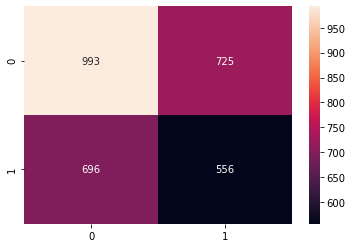

In [10]:
confusionMatrix = confusion_matrix(test_y, dummyPredictions)
seaborn.heatmap(confusionMatrix, annot = True, fmt = ".0f")

#### 'most_frequent' Dummy Classification

In [11]:
dummyClassifier = DummyClassifier(strategy = 'most_frequent')
dummyClassifier = dummyClassifier.fit(vectorTrainProc, train_y)

In [12]:
dummyPredictions = dummyClassifier.predict(vectorTestProc)

print('__MOST_FREQ. DUMMY CLASSIFIER RESULTS__',  "\n" )
print('Accuracy: ', metrics.accuracy_score(test_y, dummyPredictions))
print('F1 Macro: ', metrics.f1_score(test_y, dummyPredictions, average = 'macro'), "\n")
print('Clasification Report: ', "\n" , metrics.classification_report(test_y, dummyPredictions, zero_division = 0))

__MOST_FREQ. DUMMY CLASSIFIER RESULTS__ 

Accuracy:  0.5784511784511784
F1 Macro:  0.36646757679180886 

Clasification Report:  
               precision    recall  f1-score   support

           0       0.58      1.00      0.73      1718
           1       0.00      0.00      0.00      1252

    accuracy                           0.58      2970
   macro avg       0.29      0.50      0.37      2970
weighted avg       0.33      0.58      0.42      2970



<AxesSubplot:>

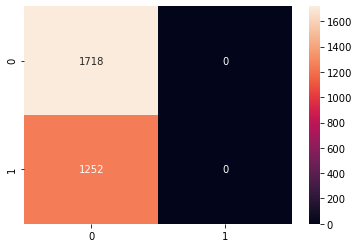

In [53]:
confusionMatrix = confusion_matrix(test_y, dummyPredictions)
seaborn.heatmap(confusionMatrix, annot = True, fmt = ".0f")

## Decision Tree Classification

In [54]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
decisionTreeClassif = DecisionTreeClassifier(criterion = "entropy", min_samples_split = 10)
params = {
    'criterion' : ["entropy", "gini"],
    'max_depth':[2,4,6,8,10,12],
    "max_features": ['auto', 'log2', 'sqrt']
}

gridSCV = GridSearchCV(estimator = decisionTreeClassif, param_grid = params, scoring = 'f1_macro',  cv = 5, n_jobs = 6, verbose = 1)
gridSCV.fit(vectorTrainProc, train_y)
decisionTreeClassif = decisionTreeClassif.fit(vectorTrainProc, train_y)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    7.5s
[Parallel(n_jobs=6)]: Done 180 out of 180 | elapsed:    8.3s finished


In [55]:
treePredictions = decisionTreeClassif.predict(vectorTestProc)


print('__DECISION TREE CLASSIFIER RESULTS__',  "\n" )
print('Accuracy: ', metrics.accuracy_score(test_y, treePredictions))
print('F1 Macro: ', metrics.f1_score(test_y, treePredictions, average = 'macro'), "\n")
print('Clasification Report: ', "\n" , metrics.classification_report(test_y, treePredictions, zero_division = 0))

__DECISION TREE CLASSIFIER RESULTS__ 

Accuracy:  0.48148148148148145
F1 Macro:  0.44852941176470584 

Clasification Report:  
               precision    recall  f1-score   support

           0       0.67      0.20      0.31      1718
           1       0.44      0.86      0.58      1252

    accuracy                           0.48      2970
   macro avg       0.56      0.53      0.45      2970
weighted avg       0.57      0.48      0.43      2970



<AxesSubplot:>

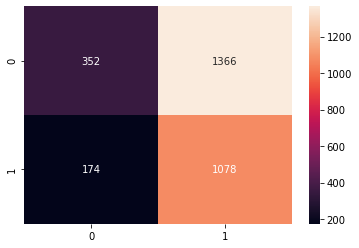

In [56]:
confusionMatrix = confusion_matrix(test_y, treePredictions)
seaborn.heatmap(confusionMatrix, annot = True, fmt = ".0f")

## C-Support Vector Classification

In [58]:
%%time
cSuppVector = SVC(C = 1, verbose = 1)
params = {
    'gamma' : ['scale', 'auto'],
    'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
    'decision_function_shape': ['ovo', 'ovr']
}
              
cSuppVector = GridSearchCV(estimator = cSuppVector, param_grid = params, cv = 3, scoring = 'f1_macro', n_jobs = 6, verbose = 1)
cSuppVector = cSuppVector.fit(vectorTrainProc, train_y)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  48 out of  48 | elapsed:  1.2min finished


[LibSVM]Wall time: 1min 21s


In [59]:
cSuppVectorPredictions = cSuppVector.predict(vectorTestProc)


print('__C-SUPPORT VECTOR CLASSIFIER RESULTS__',  "\n" )
print('Accuracy: ', metrics.accuracy_score(test_y, cSuppVectorPredictions))
print('F1 Macro: ', metrics.f1_score(test_y, cSuppVectorPredictions, average = 'macro'), "\n")
print('Clasification Report: ', "\n" , metrics.classification_report(test_y, cSuppVectorPredictions, zero_division = 0))

__C-SUPPORT VECTOR CLASSIFIER RESULTS__ 

Accuracy:  0.49057239057239055
F1 Macro:  0.4529367271406256 

Clasification Report:  
               precision    recall  f1-score   support

           0       0.72      0.20      0.31      1718
           1       0.45      0.89      0.60      1252

    accuracy                           0.49      2970
   macro avg       0.58      0.55      0.45      2970
weighted avg       0.60      0.49      0.43      2970



<AxesSubplot:>

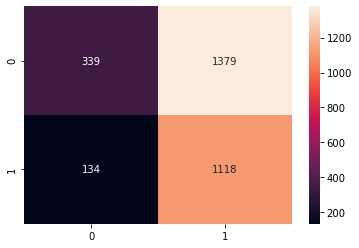

In [60]:
confusionMatrix = confusion_matrix(test_y, cSuppVectorPredictions)
seaborn.heatmap(confusionMatrix, annot = True, fmt = ".0f")

## Linear SVC 

In [66]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import FeatureUnion, Pipeline 
from sklearn.svm import LinearSVC
estPipe = Pipeline([('union', FeatureUnion([
                                             ('word_vec', CountVectorizer(analyzer = 'word')),
                                             ('char_vec', CountVectorizer(analyzer = 'char'))
                                             ])),
                     ('transform', TfidfTransformer()),
                     ('clf', LinearSVC(C = 0.35, class_weight = 'balanced'
                                ))])

params = {
    'union__char_vec__binary': [True, False],
    'union__word_vec__binary': [True, False],
    'clf__loss': ['hinge', 'squared_hinge'],
}

grid_search = GridSearchCV(estimator = estPipe, param_grid = params, cv = 3, scoring = 'f1_macro', n_jobs = 6, verbose = 1)
grid_search.fit(train_x, train_y)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  24 out of  24 | elapsed:    2.4s finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('union',
                                        FeatureUnion(transformer_list=[('word_vec',
                                                                        CountVectorizer()),
                                                                       ('char_vec',
                                                                        CountVectorizer(analyzer='char'))])),
                                       ('transform', TfidfTransformer()),
                                       ('clf',
                                        LinearSVC(C=0.35,
                                                  class_weight='balanced'))]),
             n_jobs=6,
             param_grid={'clf__loss': ['hinge', 'squared_hinge'],
                         'union__char_vec__binary': [True, False],
                         'union__word_vec__binary': [True, False]},
             scoring='f1_macro', verbose=1)

In [67]:
linearSVCPred = grid_search.predict(test_x)


print('__LINEAR SV CLASSIFIER RESULTS__',  "\n" )
print('Accuracy: ', metrics.accuracy_score(test_y, linearSVCPred))
print('F1 Macro: ', metrics.f1_score(test_y, linearSVCPred, average = 'macro'), "\n")
print('Clasification Report: ', "\n" , metrics.classification_report(test_y, linearSVCPred, zero_division = 0))

__LINEAR SV CLASSIFIER RESULTS__ 

Accuracy:  0.48922558922558923
F1 Macro:  0.4404349055630121 

Clasification Report:  
               precision    recall  f1-score   support

           0       0.77      0.17      0.28      1718
           1       0.45      0.93      0.61      1252

    accuracy                           0.49      2970
   macro avg       0.61      0.55      0.44      2970
weighted avg       0.63      0.49      0.41      2970



<AxesSubplot:>

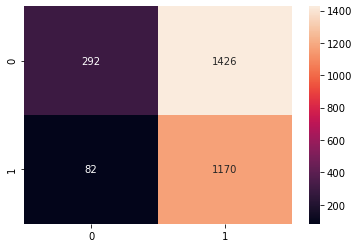

In [63]:
confusionMatrix = confusion_matrix(test_y, linearSVCPred)
seaborn.heatmap(confusionMatrix, annot = True, fmt = ".0f")

## Random Forest Classifier

In [68]:
x_train, x_test, y_train, y_test = train_test_split(
    train_x, train_y, test_size = 0.33, random_state = 0, shuffle = True)

classifier = Pipeline([("tf-idf", TfidfVectorizer()), ("classr", RandomForestClassifier(
        n_estimators=100, warm_start=True, verbose=1))])

classifier.fit(train_x, train_y)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.5s finished


Pipeline(steps=[('tf-idf', TfidfVectorizer()),
                ('classr', RandomForestClassifier(verbose=1, warm_start=True))])

In [69]:
forrestPredictions = classifier.predict(test_x)

print('__ FOREST CLASSIFIER RESULTS__',  "\n" )
print('Accuracy: ', metrics.accuracy_score(test_y, forrestPredictions))
print('F1 Macro: ', metrics.f1_score(test_y, forrestPredictions, average = 'macro'), "\n")
print('Clasification Report: ', "\n" , metrics.classification_report(test_y, forrestPredictions, zero_division = 0))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


__ FOREST CLASSIFIER RESULTS__ 

Accuracy:  0.47474747474747475
F1 Macro:  0.4251980890553409 

Clasification Report:  
               precision    recall  f1-score   support

           0       0.71      0.16      0.26      1718
           1       0.44      0.91      0.59      1252

    accuracy                           0.47      2970
   macro avg       0.57      0.53      0.43      2970
weighted avg       0.60      0.47      0.40      2970



<AxesSubplot:>

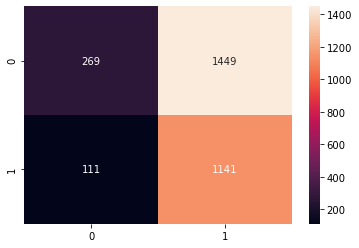

In [70]:
confusionMatrix = confusion_matrix(test_y, forrestPredictions)
seaborn.heatmap(confusionMatrix, annot = True, fmt = ".0f")

## Naive Bayes Classifier 

In [71]:
%%time
naiveBayers = MultinomialNB()
params = {
    'fit_prior': [True, False],
}

naiveBayers = GridSearchCV(estimator = naiveBayers, param_grid = params, 
                           n_jobs = 5, cv = 3, scoring = 'f1_macro', verbose = 1)

naiveBayers = naiveBayers.fit(vectorTrainProc, train_y)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Wall time: 179 ms


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   6 out of   6 | elapsed:    0.1s finished


In [73]:
bayerPrediction = naiveBayers.predict(vectorTestProc)

print('__BAYER CLASSIFIER RESULTS__',  "\n" )
print('Accuracy: ', metrics.accuracy_score(test_y, bayerPrediction))
print('F1 Macro: ', metrics.f1_score(test_y, bayerPrediction, average = 'macro'), "\n")
print('Clasification Report: ', "\n" , metrics.classification_report(test_y, bayerPrediction, zero_division = 0))

__FOREST CLASSIFIER RESULTS__ 

Accuracy:  0.47575757575757577
F1 Macro:  0.41272674926668473 

Clasification Report:  
               precision    recall  f1-score   support

           0       0.79      0.13      0.22      1718
           1       0.44      0.95      0.61      1252

    accuracy                           0.48      2970
   macro avg       0.62      0.54      0.41      2970
weighted avg       0.64      0.48      0.38      2970



<AxesSubplot:>

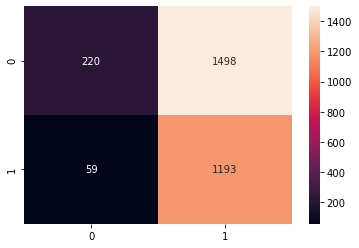

In [74]:
confusionMatrix = confusion_matrix(test_y, bayerPrediction)
seaborn.heatmap(confusionMatrix, annot = True, fmt = ".0f")

### BERT Classifier

In [26]:
x_train, x_test, y_train, y_test, preproc = text.texts_from_df(train_df = train_processedTweets, 
                   text_column = 'processed_tweet',
                   label_columns = 'label',
                   val_df = val_x,
                   maxlen = 240,
                   preprocess_mode = 'bert')


model = text.text_classifier(name = 'bert',
                             train_data = (train_x, train_y),
                             preproc = preproc)

learner = ktrain.get_learner(model=model,
                             train_data=(train_x, train_y),
                             val_data=(val_x, val_y),
                             batch_size=10
                            )



KeyError: 'processed_tweet'

In [ ]:
learner.fit_onecycle(lr=2e-5, epochs=2)

predictor = ktrain.get_predictor(learner.model, preprocess)